In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [3]:
num_samples = 100
sample_range = range(0, 100)

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [4]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.25, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(range(num_samples), desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing SNR Levels:  83%|████████▎ | 5/6 [01:37<00:18, 18.91s/it]

Converged after 406 outer iterations



Processing Samples:   1%|          | 1/100 [01:56<3:12:05, 116.42s/it]

Converged after 417 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:16<00:37, 18.63s/it]

Converged after 387 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:32<00:17, 17.69s/it]

Converged after 394 outer iterations



Processing Samples:   2%|▏         | 2/100 [03:39<2:57:18, 108.55s/it]

Converged after 286 outer iterations



Processing Samples:   3%|▎         | 3/100 [05:32<2:58:27, 110.39s/it]

Converged after 319 outer iterations



Processing Samples:   4%|▍         | 4/100 [07:24<2:57:36, 111.01s/it]

Converged after 345 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:43<00:18, 18.92s/it]

Converged after 317 outer iterations



Processing Samples:   5%|▌         | 5/100 [09:22<2:59:59, 113.68s/it]

Converged after 368 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:32<00:17, 17.38s/it]

Converged after 322 outer iterations



Processing Samples:   6%|▌         | 6/100 [11:07<2:53:35, 110.80s/it]

Converged after 299 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:42<00:20, 20.01s/it]

Converged after 403 outer iterations



Processing Samples:   7%|▋         | 7/100 [13:04<2:54:56, 112.87s/it]

Converged after 338 outer iterations



Processing Samples:   8%|▊         | 8/100 [15:10<2:59:23, 116.99s/it]

Converged after 430 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:42<00:20, 20.34s/it]

Converged after 435 outer iterations



Processing Samples:   9%|▉         | 9/100 [17:11<2:59:11, 118.15s/it]

Converged after 417 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:22<00:41, 20.85s/it]

Converged after 486 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:45<00:21, 21.60s/it]

Converged after 478 outer iterations



Processing Samples:  10%|█         | 10/100 [19:14<2:59:26, 119.63s/it]

Converged after 433 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.02s/it]

Converged after 348 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:32<00:17, 17.71s/it]

Converged after 444 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:20<00:40, 20.03s/it]

Converged after 467 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.07s/it]

Converged after 395 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:19<00:39, 19.52s/it]

Converged after 421 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:18, 18.48s/it]

Converged after 420 outer iterations



Processing Samples:  13%|█▎        | 13/100 [24:52<2:46:07, 114.57s/it]

Converged after 260 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:20<00:39, 19.80s/it]

Converged after 460 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.19s/it]

Converged after 349 outer iterations



Processing Samples:  14%|█▍        | 14/100 [26:50<2:45:50, 115.71s/it]

Converged after 473 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:20<00:40, 20.26s/it]

Converged after 492 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.14s/it]

Converged after 435 outer iterations



Processing Samples:  15%|█▌        | 15/100 [28:42<2:42:23, 114.63s/it]

Converged after 333 outer iterations



Processing Samples:  16%|█▌        | 16/100 [30:40<2:41:52, 115.63s/it]

Converged after 277 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.59s/it]

Converged after 415 outer iterations



Processing Samples:  17%|█▋        | 17/100 [32:40<2:41:46, 116.95s/it]

Converged after 429 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:40<00:19, 19.76s/it]

Converged after 495 outer iterations



Processing Samples:  18%|█▊        | 18/100 [34:34<2:38:39, 116.09s/it]

Converged after 315 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:40<00:19, 19.51s/it]

Converged after 428 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:41<00:19, 19.43s/it]

Converged after 412 outer iterations



Processing Samples:  20%|██        | 20/100 [38:33<2:37:04, 117.80s/it]

Converged after 422 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:18, 18.81s/it]

Converged after 398 outer iterations



Processing Samples:  21%|██        | 21/100 [40:22<2:31:28, 115.04s/it]

Converged after 263 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:41<00:20, 20.33s/it]

Converged after 440 outer iterations



Processing Samples:  22%|██▏       | 22/100 [42:12<2:27:43, 113.63s/it]

Converged after 291 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:22<00:40, 20.37s/it]

Converged after 427 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.18s/it]

Converged after 434 outer iterations



Processing Samples:  23%|██▎       | 23/100 [44:07<2:26:19, 114.02s/it]

Converged after 373 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:21<00:39, 19.84s/it]

Converged after 454 outer iterations



Processing Samples:  24%|██▍       | 24/100 [46:10<2:27:40, 116.59s/it]

Converged after 480 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.43s/it]

Converged after 391 outer iterations



Processing Samples:  25%|██▌       | 25/100 [48:01<2:23:51, 115.09s/it]

Converged after 388 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:23<00:41, 20.94s/it]

Converged after 482 outer iterations



Processing Samples:  26%|██▌       | 26/100 [49:58<2:22:35, 115.62s/it]

Converged after 287 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:18<01:31, 18.33s/it]

Converged after 475 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [01:03<01:04, 21.62s/it]

Converged after 499 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:22<00:41, 20.74s/it]

Converged after 482 outer iterations



Processing Samples:  27%|██▋       | 27/100 [51:57<2:21:39, 116.43s/it]

Converged after 290 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:19<00:39, 19.97s/it]

Converged after 459 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:32<00:17, 17.17s/it]

Converged after 279 outer iterations



Processing Samples:  28%|██▊       | 28/100 [53:46<2:17:05, 114.24s/it]

Converged after 412 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:37<00:18, 18.87s/it]

Converged after 396 outer iterations



Processing Samples:  29%|██▉       | 29/100 [55:36<2:13:38, 112.93s/it]

Converged after 293 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.14s/it]

Converged after 375 outer iterations



Processing Samples:  30%|███       | 30/100 [57:28<2:11:44, 112.92s/it]

Converged after 363 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:19<00:39, 19.55s/it]

Converged after 431 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:18, 18.42s/it]

Converged after 407 outer iterations



Processing Samples:  31%|███       | 31/100 [59:19<2:09:11, 112.34s/it]

Converged after 339 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:36<01:11, 17.91s/it]

Converged after 410 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.75s/it]

Converged after 426 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.51s/it]

Converged after 361 outer iterations



Processing Samples:  32%|███▏      | 32/100 [1:01:04<2:04:44, 110.07s/it]

Converged after 320 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.21s/it]

Converged after 441 outer iterations



Processing Samples:  33%|███▎      | 33/100 [1:02:59<2:04:35, 111.57s/it]

Converged after 449 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:23<00:41, 20.75s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:42<00:19, 19.93s/it]

Converged after 478 outer iterations



Processing Samples:  34%|███▍      | 34/100 [1:04:57<2:04:37, 113.30s/it]

Converged after 351 outer iterations



Processing Samples:  35%|███▌      | 35/100 [1:07:00<2:05:57, 116.27s/it]

Converged after 500 outer iterations



Processing Samples:  36%|███▌      | 36/100 [1:09:00<2:05:11, 117.37s/it]

Converged after 342 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [01:02<01:01, 20.60s/it]

Converged after 468 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:44<00:20, 20.54s/it]

Converged after 452 outer iterations



Processing Samples:  37%|███▋      | 37/100 [1:11:02<2:04:44, 118.79s/it]

Converged after 421 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:19<00:38, 19.20s/it]

Converged after 441 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.02s/it]

Converged after 397 outer iterations



Processing Samples:  38%|███▊      | 38/100 [1:12:53<2:00:14, 116.36s/it]

Converged after 367 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:44<00:20, 20.47s/it]

Converged after 485 outer iterations



Processing Samples:  39%|███▉      | 39/100 [1:14:53<1:59:25, 117.47s/it]

Converged after 389 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:34<00:17, 17.57s/it]

Converged after 348 outer iterations



Processing Samples:  40%|████      | 40/100 [1:16:47<1:56:36, 116.60s/it]

Converged after 393 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:18, 18.48s/it]

Converged after 366 outer iterations



Processing Samples:  41%|████      | 41/100 [1:18:37<1:52:35, 114.50s/it]

Converged after 313 outer iterations



Processing Samples:  42%|████▏     | 42/100 [1:20:37<1:52:27, 116.33s/it]

Converged after 482 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [01:00<01:01, 20.43s/it]

Converged after 485 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:17<00:37, 18.94s/it]

Converged after 421 outer iterations



Processing Samples:  43%|████▎     | 43/100 [1:22:29<1:49:07, 114.87s/it]

Converged after 338 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:20<00:39, 19.87s/it]

Converged after 430 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.51s/it]

Converged after 447 outer iterations



Processing Samples:  44%|████▍     | 44/100 [1:24:26<1:47:55, 115.63s/it]

Converged after 459 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:16<00:36, 18.26s/it]

Converged after 352 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:30<00:16, 16.70s/it]

Converged after 324 outer iterations



Processing Samples:  45%|████▌     | 45/100 [1:26:08<1:42:06, 111.39s/it]

Converged after 236 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:19<00:38, 19.38s/it]

Converged after 421 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:37<00:18, 18.76s/it]

Converged after 460 outer iterations



Processing Samples:  46%|████▌     | 46/100 [1:28:02<1:40:57, 112.18s/it]

Converged after 404 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:30:03<1:41:30, 114.92s/it]

Converged after 483 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:26<00:44, 22.02s/it]

Converged after 494 outer iterations



Processing Samples:  48%|████▊     | 48/100 [1:32:04<1:41:09, 116.73s/it]

Converged after 377 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:40<00:19, 19.66s/it]

Converged after 417 outer iterations



Processing Samples:  49%|████▉     | 49/100 [1:33:57<1:38:13, 115.55s/it]

Converged after 350 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:42<00:19, 19.55s/it]

Converged after 439 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:35:52<1:36:17, 115.56s/it]

Converged after 297 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:17<00:37, 18.91s/it]

Converged after 388 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:29<00:16, 16.39s/it]

Converged after 266 outer iterations



Processing Samples:  51%|█████     | 51/100 [1:37:36<1:31:31, 112.07s/it]

Converged after 322 outer iterations



Processing Samples:  52%|█████▏    | 52/100 [1:39:38<1:32:02, 115.05s/it]

Converged after 442 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [01:01<01:02, 20.74s/it]

Converged after 491 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.05s/it]

Converged after 342 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:41:30<1:29:18, 114.01s/it]

Converged after 408 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:41<00:19, 19.80s/it]

Converged after 430 outer iterations



Processing Samples:  54%|█████▍    | 54/100 [1:43:30<1:28:50, 115.88s/it]

Converged after 456 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [01:01<01:01, 20.55s/it]

Converged after 485 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:43<00:20, 20.71s/it]

Converged after 479 outer iterations



Processing Samples:  55%|█████▌    | 55/100 [1:45:26<1:26:57, 115.94s/it]

Converged after 264 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.52s/it]

Converged after 404 outer iterations



Processing Samples:  56%|█████▌    | 56/100 [1:47:20<1:24:32, 115.28s/it]

Converged after 325 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:40<00:19, 19.23s/it]

Converged after 356 outer iterations



Processing Samples:  57%|█████▋    | 57/100 [1:49:18<1:23:15, 116.16s/it]

Converged after 405 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:43<00:20, 20.39s/it]

Converged after 403 outer iterations



Processing Samples:  59%|█████▉    | 59/100 [1:53:24<1:21:45, 119.64s/it]

Converged after 437 outer iterations



Processing Samples:  60%|██████    | 60/100 [1:55:22<1:19:27, 119.19s/it]

Converged after 328 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:16<00:37, 18.64s/it]

Converged after 384 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:32<00:17, 17.81s/it]

Converged after 402 outer iterations



Processing Samples:  61%|██████    | 61/100 [1:57:09<1:15:08, 115.61s/it]

Converged after 350 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:43<01:26, 21.70s/it]

Converged after 489 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [01:02<01:02, 20.76s/it]

Converged after 478 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:17<00:37, 18.55s/it]

Converged after 373 outer iterations



Processing Samples:  62%|██████▏   | 62/100 [1:59:01<1:12:32, 114.53s/it]

Converged after 359 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:24<00:41, 20.96s/it]

Converged after 487 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:17, 17.92s/it]

Converged after 312 outer iterations



Processing Samples:  63%|██████▎   | 63/100 [2:00:55<1:10:23, 114.16s/it]

Converged after 376 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:18<00:39, 19.51s/it]

Converged after 397 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.50s/it]

Converged after 485 outer iterations



Processing Samples:  64%|██████▍   | 64/100 [2:02:49<1:08:27, 114.08s/it]

Converged after 384 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:18<00:37, 18.92s/it]

Converged after 435 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [2:04:46<1:07:05, 115.00s/it]

Converged after 373 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:21<00:40, 20.03s/it]

Converged after 488 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:43<00:20, 20.64s/it]

Converged after 465 outer iterations



Processing Samples:  66%|██████▌   | 66/100 [2:06:47<1:06:09, 116.74s/it]

Converged after 420 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:18<00:39, 19.58s/it]

Converged after 453 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.24s/it]

Converged after 449 outer iterations



Processing Samples:  67%|██████▋   | 67/100 [2:08:45<1:04:25, 117.15s/it]

Converged after 460 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:41<00:19, 19.96s/it]

Converged after 495 outer iterations
Converged after 378 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:22<00:39, 19.90s/it]

Converged after 437 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:17, 17.71s/it]

Converged after 331 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [2:12:27<58:37, 113.46s/it]  

Converged after 267 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [01:00<00:59, 19.82s/it]

Converged after 490 outer iterations
Converged after 414 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.01s/it]

Converged after 424 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:17<00:37, 18.62s/it]

Converged after 388 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:33<00:17, 17.84s/it]

Converged after 414 outer iterations



Processing Samples:  71%|███████   | 71/100 [2:16:09<54:01, 111.77s/it]

Converged after 277 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:43<00:21, 21.05s/it]

Converged after 490 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:20<00:40, 20.08s/it]

Converged after 398 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.40s/it]

Converged after 381 outer iterations



Processing Samples:  73%|███████▎  | 73/100 [2:20:02<51:01, 113.39s/it]

Converged after 309 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:42<00:20, 20.18s/it]

Converged after 466 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:42<00:20, 20.30s/it]

Converged after 457 outer iterations



Processing Samples:  75%|███████▌  | 75/100 [2:23:59<48:18, 115.92s/it]

Converged after 331 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:55<00:55, 18.51s/it]

Converged after 446 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:17<00:39, 19.88s/it]

Converged after 497 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.54s/it]

Converged after 307 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [2:25:37<44:15, 110.66s/it]

Converged after 227 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:41<00:19, 19.74s/it]

Converged after 405 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [2:27:32<42:52, 111.87s/it]

Converged after 293 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:20<00:40, 20.03s/it]

Converged after 488 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.41s/it]

Converged after 479 outer iterations



Processing Samples:  78%|███████▊  | 78/100 [2:29:24<40:59, 111.78s/it]

Converged after 305 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:21<00:40, 20.03s/it]

Converged after 486 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:43<00:20, 20.61s/it]

Converged after 477 outer iterations



Processing Samples:  79%|███████▉  | 79/100 [2:31:20<39:37, 113.21s/it]

Converged after 334 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:41<00:19, 19.88s/it]

Converged after 475 outer iterations



Processing Samples:  80%|████████  | 80/100 [2:33:17<38:04, 114.22s/it]

Converged after 383 outer iterations



Processing Samples:  81%|████████  | 81/100 [2:35:22<37:15, 117.66s/it]

Converged after 442 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.06s/it]

Converged after 420 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:37:14<34:47, 115.97s/it]

Converged after 345 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.24s/it]

Converged after 405 outer iterations



Processing Samples:  83%|████████▎ | 83/100 [2:39:12<32:58, 116.37s/it]

Converged after 410 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.72s/it]

Converged after 478 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:36<00:18, 18.49s/it]

Converged after 369 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [2:43:08<29:12, 116.85s/it]

Converged after 443 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:22<00:40, 20.35s/it]

Converged after 458 outer iterations



Processing Samples:  86%|████████▌ | 86/100 [2:45:05<27:18, 117.06s/it]

Converged after 386 outer iterations



Processing Samples:  87%|████████▋ | 87/100 [2:47:07<25:39, 118.41s/it]

Converged after 468 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:17<00:37, 18.53s/it]

Converged after 425 outer iterations



Processing Samples:  88%|████████▊ | 88/100 [2:49:03<23:32, 117.71s/it]

Converged after 405 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.16s/it]

Converged after 461 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [2:50:58<21:26, 116.92s/it]

Converged after 441 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:59<00:56, 18.82s/it]

Converged after 402 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:21<00:40, 20.23s/it]

Converged after 495 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:38<00:18, 18.95s/it]

Converged after 399 outer iterations



Processing Samples:  90%|█████████ | 90/100 [2:52:52<19:20, 116.01s/it]

Converged after 390 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:18<00:38, 19.21s/it]

Converged after 431 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.14s/it]

Converged after 410 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:19<00:38, 19.37s/it]

Converged after 424 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.26s/it]

Converged after 415 outer iterations



Processing Samples:  92%|█████████▏| 92/100 [2:56:39<15:15, 114.49s/it]

Converged after 359 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:59<01:00, 20.27s/it]

Converged after 470 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.30s/it]

Converged after 354 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [2:58:31<13:14, 113.54s/it]

Converged after 419 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:18<00:38, 19.19s/it]

Converged after 448 outer iterations
Converged after 382 outer iterations



Processing Samples:  94%|█████████▍| 94/100 [3:00:28<11:28, 114.74s/it]

Converged after 473 outer iterations



Processing Samples:  95%|█████████▌| 95/100 [3:02:32<09:47, 117.52s/it]

Converged after 444 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:19<00:38, 19.10s/it]

Converged after 419 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:33<00:17, 17.48s/it]

Converged after 358 outer iterations



Processing Samples:  96%|█████████▌| 96/100 [3:04:21<07:39, 114.99s/it]

Converged after 372 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.08s/it]

Converged after 378 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:20<00:39, 19.97s/it]

Converged after 478 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [3:08:20<03:54, 117.13s/it]

Converged after 386 outer iterations



Processing Samples:  99%|█████████▉| 99/100 [3:10:16<01:56, 116.98s/it]

Converged after 345 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:45<00:20, 20.30s/it]

Converged after 489 outer iterations



Processing Samples: 100%|██████████| 100/100 [3:12:15<00:00, 115.36s/it]

Converged after 330 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [ 69.1   90.6   97.5   99.6   99.85 100.  ]
Avg SRR : [0.37558972 0.61504515 0.81109984 0.96018718 0.99490969 1.        ]
Avg FR  : [3.37631579 2.19736842 1.01578947 0.2        0.02105263 0.        ]
Avg PR  : [0.52616095 0.69039278 0.84085153 0.96563979 0.99643892 1.        ]
Avg RE  : [0.691  0.906  0.975  0.996  0.9985 1.    ]
Avg F1  : [0.59554796 0.78208485 0.90140975 0.98008459 0.99741917 1.        ]
Avg NMSE: [0.55333777 0.3074815  0.15251522 0.05296837 0.01987049 0.00748606]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-100-casbl-anc-alpha-1-25-beta-0-10-snr-db-all-pilot-length-30.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


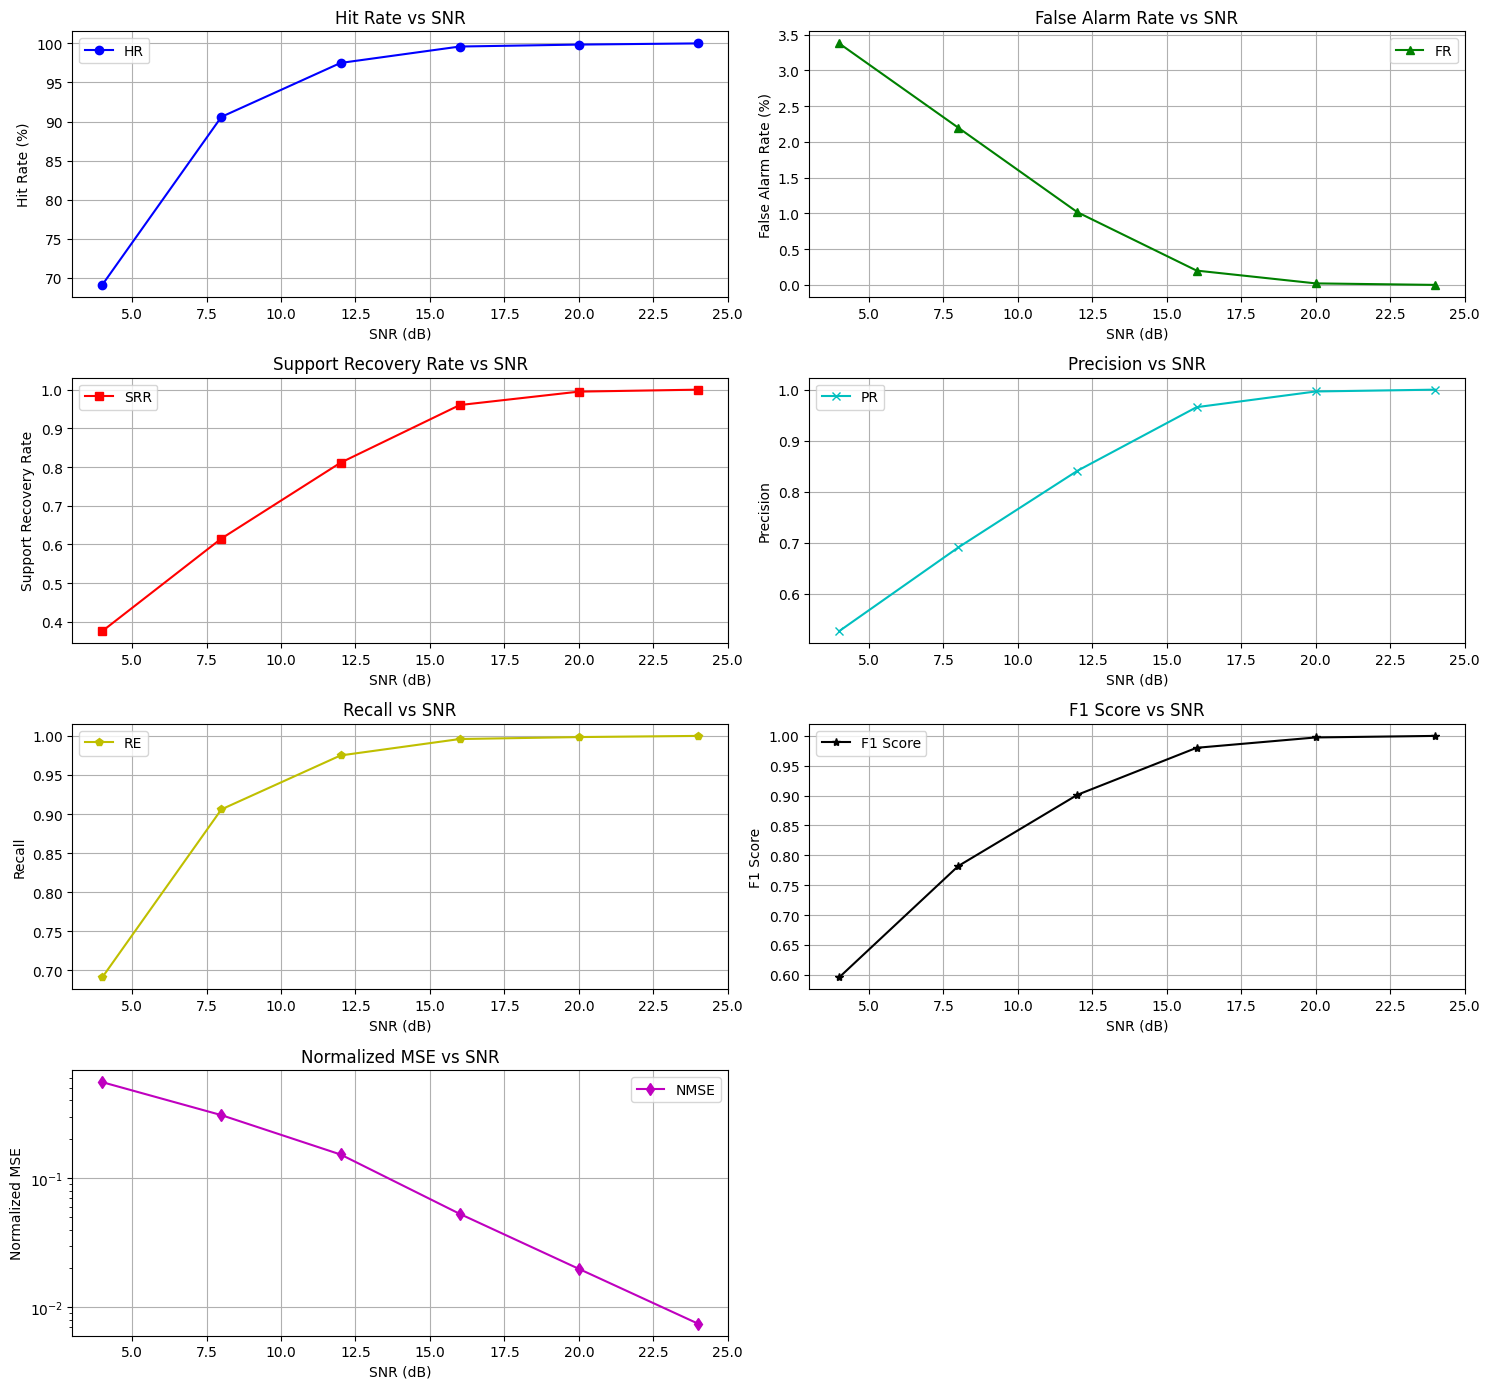

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

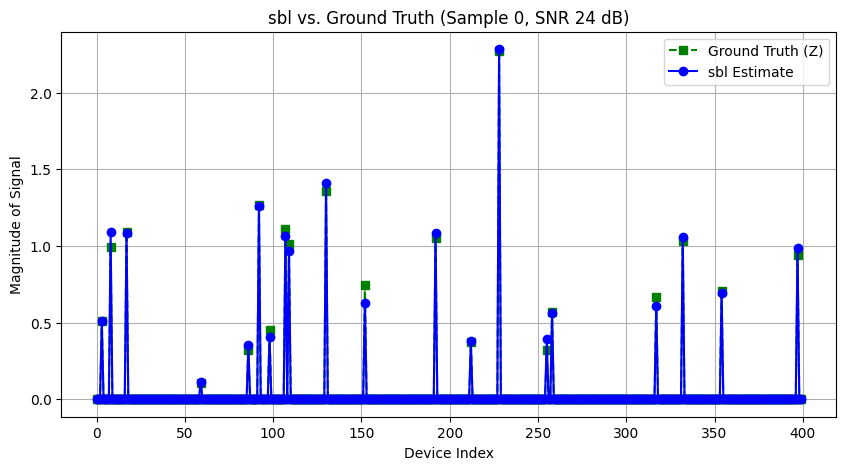

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


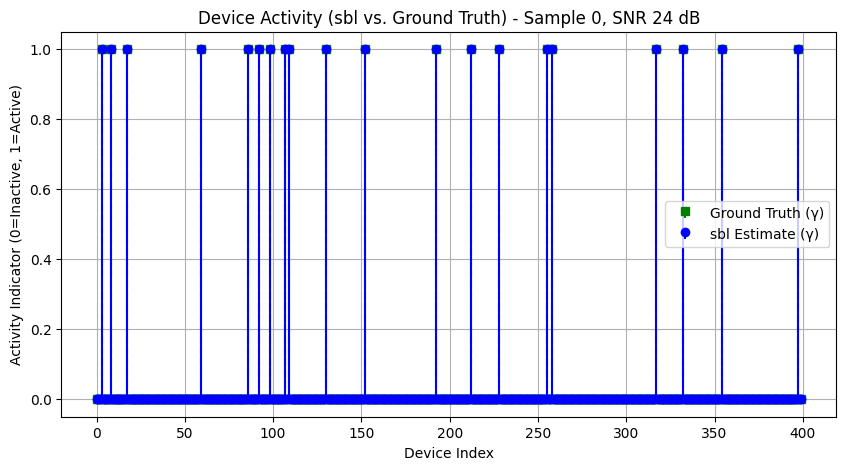

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)